# Import necessary modules / Packages

In [1]:
import twint
import time
import json

import os
from os import path

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *

import datetime
import emoji
import re

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

# Scrape data from Twitter using Twint

In [ ]:
# Set up configurations
c = twint.Config()    
c.Store_csv = True # Store to json
c.Since = "2021-01-06 00:00:00" # Set start date for collection
c.Until = "2021-02-17 00:00:00" # Set end date for collection
c.Retweets = True # Include retweets done by user
c.Lang = "en" # Set language
c.Limit = 100000 # Set tweet limit to 100k 
# c.Near = "Singapore" # Set geograpic location 
c.Search = "trump impeachment" # Set search term
c.Output = "../Data/trump_impeachment_all_counties.csv" # Save output in current directory containing python script

# Run
twint.run.Search(c)

# Prepare basic dataframe for further processing

In [15]:
# read raw csv file
df = pd.read_csv('../Data/trump_impeachment_all_countries3.csv')

# combine 'date' and 'time' column into one column
df['date_time'] = df[['date', 'time']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# drop records with tweets that are non-english
df = df.drop(df[df.language != 'en'].index)

# drop unnecessary columns
df.drop(['quote_url', 'thumbnail', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 'trans_src', 'trans_dest', 'cashtags', 'timezone', 'created_at', 'retweet', 'near', 'urls', 'photos', 'replies_count', 'retweets_count', 'link', 'video', 'reply_to', 'place', 'conversation_id', 'name', 'username', 'mentions', 'hashtags', 'language', 'date', 'time'], axis='columns', inplace=True)

# rename 'tweet' column to 'comment' to standardise column names
df.rename(columns={'tweet':'comment_raw', 'id':'comment_id'}, inplace=True)

# insert 'platform' column, and label it 'twitter'
df.insert(2, 'platform', 'twitter')

# rearrange columns to standardise with Instagram data
cols = list(df.columns)
cols = cols[:3] + [cols[5]] + [cols[4]] + [cols[3]]
df2 = df[cols]
df2


,comment_id,user_id,platform,date_time,likes_count,comment_raw
0,1.361830e+18,1.103700e+18,twitter,17/2/21 7:58:28,0,Will not being convicted end up spurring more ...
1,1.361830e+18,5.616902e+08,twitter,17/2/21 7:57:57,0,"Trump Impeachment Attorney SLAMS News Anchor, ..."
2,1.361830e+18,1.103700e+18,twitter,17/2/21 7:57:07,0,@MichaelCohen212 @RudyGiuliani @POTUS45 @GOP W...
3,1.361830e+18,1.103700e+18,twitter,17/2/21 7:57:00,0,@DrJasonJohnson Will not being convicted end u...
4,1.361830e+18,1.103700e+18,twitter,17/2/21 7:56:23,0,@davidplouffe Will not being convicted end up ...
...,...,...,...,...,...,...
189019,1.346630e+18,1.156320e+18,twitter,6/1/21 9:26:07,0,@ZachMoss6 The Left will have much more yellin...
189020,1.346630e+18,1.156320e+18,twitter,6/1/21 9:23:22,1,@jimmy_dore The Squad has turned its sights to...
189021,1.346620e+18,7.737470e+17,twitter,6/1/21 9:09:51,0,@emptywheel Lawsuits have not been working for...
189022,1.346620e+18,1.326250e+18,twitter,6/1/21 9:08:52,0,Progressives plot 11th-hour Trump impeachment ...


In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175749 entries, 0 to 189023
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   comment_id   175749 non-null  float64
 1   user_id      175749 non-null  float64
 2   platform     175749 non-null  object 
 3   date_time    175749 non-null  object 
 4   likes_count  175749 non-null  int64  
 5   comment_raw  175749 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 9.4+ MB


# Conduct text preprocessing on 'comment_raw' column

In [17]:
# initialise lists for later
comment_cleaned_emoji_list = []
comment_cleaned_no_emoji_list = []
comment_processed_list = []

# prepare stopwords list
stopwords_list = stopwords.words('english')
stopwords_list += ['donald', 'trump', 'impeachment', 'amp', 'live', 'update', 'via'] #additional stopwords customised based on context

# iterate through every comment in the dataframe
for text in df2['comment_raw']:
    text = re.sub(r"(?:\@|\#|https?\://)\S+", "", text) # remove hashtag mentions and urls
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE) 
    text_no_emoji = emoji_pattern.sub(r'', text) # remove emojis
    text_tokenised = word_tokenize(text_no_emoji) # tokenise words
    text_lower = [w.lower() for w in text_tokenised] # change to lowercase
    text_words_only = [w for w in text_lower if re.search('^[a-z]+$',w)] # keep only english words
    text_stopremoved = [w for w in text_words_only if w not in stopwords_list] # remove stopwords

    # stemmer = PorterStemmer()
    # text_stemmed = [stemmer.stem(w) for w in text_stopremoved]
    # output.append(text_stemmed)

    # append necessary items to lists
    comment_cleaned_emoji_list.append(text)
    comment_cleaned_no_emoji_list.append(text_no_emoji)
    comment_processed_list.append(text_stopremoved)

# create new columns
df2['comment_cleaned_emoji'] = comment_cleaned_emoji_list # to be used to vader
df2['comment_cleaned_no_emoji'] = comment_cleaned_no_emoji_list # to be used for vader
df2['comment_processed'] = comment_processed_list # to be used for wordcloud
df3 = df2
df3.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw,comment_cleaned_emoji,comment_cleaned_no_emoji,comment_processed
0,1.361830e+18,1.103700e+18,twitter,17/2/21 7:58:28,0,Will not being convicted end up spurring more ...,Will not being convicted end up spurring more ...,Will not being convicted end up spurring more ...,"[convicted, end, spurring, less, actions, may,..."
1,1.361830e+18,5.616902e+08,twitter,17/2/21 7:57:57,0,"Trump Impeachment Attorney SLAMS News Anchor, ...","Trump Impeachment Attorney SLAMS News Anchor, ...","Trump Impeachment Attorney SLAMS News Anchor, ...","[attorney, slams, news, anchor, gets, walks, a..."
2,1.361830e+18,1.103700e+18,twitter,17/2/21 7:57:07,0,@MichaelCohen212 @RudyGiuliani @POTUS45 @GOP W...,Will not being convicted end up spurring m...,Will not being convicted end up spurring m...,"[convicted, end, spurring, less, actions, may,..."
3,1.361830e+18,1.103700e+18,twitter,17/2/21 7:57:00,0,@DrJasonJohnson Will not being convicted end u...,Will not being convicted end up spurring more...,Will not being convicted end up spurring more...,"[convicted, end, spurring, less, actions, may,..."
4,1.361830e+18,1.103700e+18,twitter,17/2/21 7:56:23,0,@davidplouffe Will not being convicted end up ...,Will not being convicted end up spurring more...,Will not being convicted end up spurring more...,"[convicted, end, spurring, less, actions, may,..."


# Creating WordClouds
## Basic WordCloud

In [18]:
# create list of words
wordcloud_words = []
for wordlist in df3['comment_processed']:
    for word in wordlist:
        wordcloud_words.append(word)

# create string of all words
wordcloud_string = ""
for word in wordcloud_words:
    wordcloud_string += word+" "

wordcloud_string[:500]

'convicted end spurring less actions may better attorney slams news anchor gets walks away convicted end spurring less actions may better convicted end spurring less actions may better convicted end spurring less actions may better found guilty acting like bitch towards oh well reap sow lawyer resign phila trial lawyers leadership post rift emerges within group knew scam allowed dems use must admit though would like see mitch impeached obstruction lawyer david schoen slams bruce castor incoherenc'

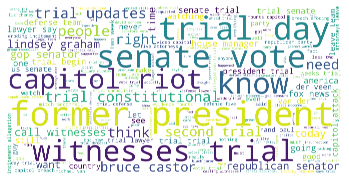

In [6]:
# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white", width=10000, height=5000).generate(wordcloud_string)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("trump_impeachment_no_stopwords.png")

## With background shape

In [11]:
mask = np.array(Image.open("../WordCloud Images/Twitter Logos/bird2.jpg"))
#photos that have values all zero are not recommended
mask

array([[[254, 254, 254],
        [254, 254, 254],
        [253, 253, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[254, 254, 254],
        [255, 255, 255],
        [254, 254, 254],
        ...,
        [252, 252, 252],
        [254, 254, 254],
        [254, 254, 254]],

       [[255, 255, 255],
        [255, 255, 255],
        [253, 253, 253],
        ...,
        [253, 253, 253],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[238, 238, 238],
        [238, 238, 238],
        [239, 239, 239],
        ...,
        [238, 238, 238],
        [238, 238, 238],
        [238, 238, 238]],

       [[239, 239, 239],
        [235, 235, 235],
        [245, 245, 245],
        ...,
        [243, 243, 243],
        [238, 238, 238],
        [238, 238, 238]],

       [[255, 255, 255],
        [253, 253, 253],
        [254, 254, 254],
        ...,
        [249, 249, 249],
        [255, 255, 255],
        [255, 255, 255]]

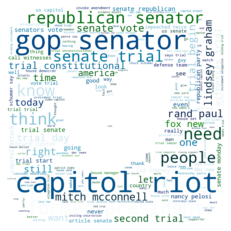

In [32]:
# Generate wordcloud
#method 1 (uses colormap)
image_colors = ImageColorGenerator(mask)
cloud = WordCloud(background_color='white', stopwords = STOPWORDS, mask=mask, colormap='ocean').generate(wordcloud_string)
# Plot
# plt.figure(figsize=[7,7])
plt.imshow(cloud,interpolation='bilinear')
plt.axis("off")
plt.show()

#saving the wordcloud
cloud.to_file('twitter_logo_word_final7.png')

# Vader Sentiment Analysis

In [33]:
# vader sentiment analysis

def vader_compound_score(sentence): 
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence) 
    return sentiment_dict['compound']

In [34]:
df3['vader_compound_emoji'] = df3['comment_cleaned_emoji'].apply(vader_compound_score) 

In [35]:
df3['vader_compound_no_emoji'] = df3['comment_cleaned_no_emoji'].apply(vader_compound_score) 

In [36]:
df3.head()

,comment_id,user_id,platform,date_time,likes_count,comment_raw,comment_cleaned_emoji,comment_cleaned_no_emoji,comment_processed,vader_compound_emoji,vader_compound_no_emoji
0,1.361830e+18,1.103700e+18,twitter,17/2/21 7:58:28,0,Will not being convicted end up spurring more ...,Will not being convicted end up spurring more ...,Will not being convicted end up spurring more ...,"[convicted, end, spurring, less, actions, may,...",0.4404,0.4404
1,1.361830e+18,5.616902e+08,twitter,17/2/21 7:57:57,0,"Trump Impeachment Attorney SLAMS News Anchor, ...","Trump Impeachment Attorney SLAMS News Anchor, ...","Trump Impeachment Attorney SLAMS News Anchor, ...","[attorney, slams, news, anchor, gets, walks, a...",0.0000,0.0000
2,1.361830e+18,1.103700e+18,twitter,17/2/21 7:57:07,0,@MichaelCohen212 @RudyGiuliani @POTUS45 @GOP W...,Will not being convicted end up spurring m...,Will not being convicted end up spurring m...,"[convicted, end, spurring, less, actions, may,...",0.4404,0.4404
3,1.361830e+18,1.103700e+18,twitter,17/2/21 7:57:00,0,@DrJasonJohnson Will not being convicted end u...,Will not being convicted end up spurring more...,Will not being convicted end up spurring more...,"[convicted, end, spurring, less, actions, may,...",0.4404,0.4404
4,1.361830e+18,1.103700e+18,twitter,17/2/21 7:56:23,0,@davidplouffe Will not being convicted end up ...,Will not being convicted end up spurring more...,Will not being convicted end up spurring more...,"[convicted, end, spurring, less, actions, may,...",0.4404,0.4404


In [37]:
df3.to_csv("trump_impeachment_all_countries_processed2.csv")

In [ ]:
plt.hist(df3.vader_score)